## Problem Statement
This project is based on a Kaggle competition called "I'm Something of a Painter Myself".
The goal of this project is to transform landscape photos into paintings in the style of Claude Monet using a General Adversarial Network (GAN).  We will specifically be using a CycleGAN, which is designed for unpaired image to image translation, or in this case real photos to Monet paintings without requiring direct image pairs.  
  
GANs consist of two neural networks:
*  Generator - creates new images
*  Discriminator - attempts to evaluate if the image is real or generated
  
CycleGANs use two generators and two discriminators.   
  
The goal of this project is to create 7,000 to 10,000 Monet-style images that appear to be authentic Monet paintings.
  
## Dataset Description
This dataset consists of Monet and Photo images.  
*  Monet images: 300 (256 X 256 pixel) images of real Monet paintings
*  Photo images: 7028 (256 X 256 pixel) images of real photo images  
  
Image files are provided in JPEG and TFRecord formats.

In [1]:
!pip install tensorflow-addons kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hurleyjer","key":"eeb2339fdf2ed25b720894fcf352fe01"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c gan-getting-started

 99% 363M/367M [00:02<00:00, 177MB/s]
100% 367M/367M [00:02<00:00, 130MB/s]


In [4]:
!unzip gan-getting-started.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/photo_jpg/46e84039a1.jpg  
  inflating: /content/dataset/photo_jpg/46f391abec.jpg  
  inflating: /content/dataset/photo_jpg/46f5ef1042.jpg  
  inflating: /content/dataset/photo_jpg/4706619607.jpg  
  inflating: /content/dataset/photo_jpg/4707b03a08.jpg  
  inflating: /content/dataset/photo_jpg/47100a9939.jpg  
  inflating: /content/dataset/photo_jpg/471f4755b9.jpg  
  inflating: /content/dataset/photo_jpg/472b351bc4.jpg  
  inflating: /content/dataset/photo_jpg/472d5ac100.jpg  
  inflating: /content/dataset/photo_jpg/4758e5dd4c.jpg  
  inflating: /content/dataset/photo_jpg/4762bb79ef.jpg  
  inflating: /content/dataset/photo_jpg/4778b13518.jpg  
  inflating: /content/dataset/photo_jpg/4787b82d37.jpg  
  inflating: /content/dataset/photo_jpg/478e07feaa.jpg  
  inflating: /content/dataset/photo_jpg/478eb12a82.jpg  
  inflating: /content/dataset/photo_jpg/479698b371.jpg  
  inflating: /content/dataset/photo_j

### Exploratory Data Analysis

In [7]:
#Load packages
import pandas as pd
import seaborn as sns
import cv2
import random
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import PIL

In [8]:
# Define paths for paintings and photos
DATA_DIR = "/content/dataset/"
MONET_PATH = os.path.join(DATA_DIR, "monet_jpg")
PHOTO_PATH = os.path.join(DATA_DIR, "photo_jpg")

In [9]:
# Load images
def load_images(path):
    files = tf.io.gfile.glob(path + "/*.jpg")
    images = [tf.image.decode_jpeg(tf.io.read_file(f)) for f in files]
    return images

monet_images = load_images(MONET_PATH)
photo_images = load_images(PHOTO_PATH)

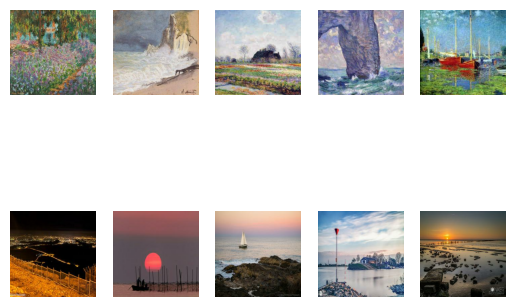

In [12]:
# Show imagesplt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(monet_images[i])
    plt.axis("off")

    plt.subplot(2, 5, i+6)
    plt.imshow(photo_images[i])
    plt.axis("off")
plt.show()

### Preprocessing
Preprocess the images by resizing and normalizing pixel values

In [14]:
# Preprocessing functions
def preprocess_image(image):
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

def load_dataset(path):
    dataset = tf.data.Dataset.list_files(path + "/*.jpg")
    dataset = dataset.map(lambda x: preprocess_image(tf.image.decode_jpeg(tf.io.read_file(x), channels=3)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    return dataset

monet_ds = load_dataset(MONET_PATH)
photo_ds = load_dataset(PHOTO_PATH)

### Model Architecture
CycleGANs consist of:
* Two generators: One transforms photos to Monet-style paintings, the second converts paintings back to photos
*  Two discriminators: Each discriminator attempts to determine if an image is real or generated

In [15]:
# Define Generator model (U-Net / ResNet-based)
def build_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu'),
    ]
    up_stack = [
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh'),
    ]

    x = inputs
    for down in down_stack:
        x = down(x)
    for up in up_stack:
        x = up(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
# Define Discriminator model
def build_discriminator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(1, (4, 4), padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
# Instantiate models
generator_G = build_generator()  # Photo -> Monet
generator_F = build_generator()  # Monet -> Photo
discriminator_X = build_discriminator()  # Discriminator for Monet
discriminator_Y = build_discriminator()  # Discriminator for Photo

### Training the model

In [19]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_G(real_x, training=True)
        cycled_x = generator_F(fake_y, training=True)
        fake_x = generator_F(real_y, training=True)
        cycled_y = generator_G(fake_x, training=True)
        disc_real_x = discriminator_X(real_x, training=True)
        disc_fake_x = discriminator_X(fake_x, training=True)
        disc_real_y = discriminator_Y(real_y, training=True)
        disc_fake_y = discriminator_Y(fake_y, training=True)
        gen_G_loss = generator_loss(disc_fake_y)
        gen_F_loss = generator_loss(disc_fake_x)
        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    gen_G_grads = tape.gradient(gen_G_loss, generator_G.trainable_variables)
    gen_F_grads = tape.gradient(gen_F_loss, generator_F.trainable_variables)
    disc_X_grads = tape.gradient(disc_X_loss, discriminator_X.trainable_variables)
    disc_Y_grads = tape.gradient(disc_Y_loss, discriminator_Y.trainable_variables)
    generator_G_optimizer.apply_gradients(zip(gen_G_grads, generator_G.trainable_variables))
    generator_F_optimizer.apply_gradients(zip(gen_F_grads, generator_F.trainable_variables))
    discriminator_X_optimizer.apply_gradients(zip(disc_X_grads, discriminator_X.trainable_variables))
    discriminator_Y_optimizer.apply_gradients(zip(disc_Y_grads, discriminator_Y.trainable_variables))

EPOCHS = 10
for epoch in range(EPOCHS):
    for real_x, real_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(real_x, real_y)
    print(f"Epoch {epoch+1}/{EPOCHS} completed.")

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


In [21]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

In [25]:
# Set dataset paths
PHOTO_PATH = "/content/dataset/photo_jpg"

# Function to load and preprocess images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

# Select 7,000 photos for transformation
num_images = 7000  # Adjust to between 7,000 and 10,000
photo_files = glob.glob(PHOTO_PATH + "/*.jpg")[:num_images]

# Create output directory
output_dir = "/content/images"
os.makedirs(output_dir, exist_ok=True)

# Generate and save Monet-style images
for i, photo_path in enumerate(photo_files):
    image = load_image(photo_path)  # Load and preprocess image
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    generated_image = generator_G(image, training=False).numpy()  # Generate Monet-style image

    # Convert back to pixel range [0, 255]
    generated_image = np.squeeze(generated_image, axis=0)  # Remove batch dimension
    generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)

    # Save image in the required format
    img = PIL.Image.fromarray(generated_image)
    img.save(f"{output_dir}/image_{i}.jpg")

    if i % 500 == 0:  # Print progress every 500 images
        print(f"Generated {i} images...")

print("Generated Monet-style images saved successfully!")

Generated 0 images...
Generated 500 images...
Generated 1000 images...
Generated 1500 images...
Generated 2000 images...
Generated 2500 images...
Generated 3000 images...
Generated 3500 images...
Generated 4000 images...
Generated 4500 images...
Generated 5000 images...
Generated 5500 images...
Generated 6000 images...
Generated 6500 images...
Generated Monet-style images saved successfully!


In [26]:
# Check that 7000 images were created
print("Total images generated:", len(os.listdir(output_dir)))

Total images generated: 7000


In [27]:
# Save images to a zip file
!zip -r /content/images.zip /content/images

Streaming output truncated to the last 5000 lines.
  adding: content/images/image_6742.jpg (deflated 22%)
  adding: content/images/image_239.jpg (deflated 20%)
  adding: content/images/image_3429.jpg (deflated 27%)
  adding: content/images/image_3196.jpg (deflated 29%)
  adding: content/images/image_4907.jpg (deflated 26%)
  adding: content/images/image_4141.jpg (deflated 24%)
  adding: content/images/image_6308.jpg (deflated 28%)
  adding: content/images/image_2978.jpg (deflated 31%)
  adding: content/images/image_3639.jpg (deflated 35%)
  adding: content/images/image_4460.jpg (deflated 30%)
  adding: content/images/image_2472.jpg (deflated 25%)
  adding: content/images/image_822.jpg (deflated 21%)
  adding: content/images/image_3404.jpg (deflated 24%)
  adding: content/images/image_2500.jpg (deflated 30%)
  adding: content/images/image_3663.jpg (deflated 25%)
  adding: content/images/image_2428.jpg (deflated 28%)
  adding: content/images/image_6915.jpg (deflated 22%)
  adding: conten

In [29]:
# Download image file
from google.colab import files
files.download("/content/images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Results and summary
I've created the 7000 images, but am not able to upload due to running in Google Colab. I'm going to submit this notebook as is due to the time it takes to run in kaggle.  
  
  